# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

### GMGC v.1 homolog c_AMPs 

Here, we show how c_AMPs from AMPSphere are aligned to homolog large proteins from GMGC, their features and
distribution.


In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import log

In [2]:
# loading data
gmgc = pd.DataFrame()
for record in pd.read_table('data/result_gmgc.m8.xz',
                            header=None,
                            chunksize=1_000_000):
    gmgc = gmgc.append(record)

gmgc.columns = ['query', 'target', 'evalue',
                'gapopen', 'pident', 'nident', 
                'qstart', 'qend', 'qlen',
                'tstart', 'tend', 'tlen',
                'alnlen', 'raw', 'bits',
                'cigar', 'qseq', 'tseq',
                'qheader', 'theader', 'qaln',
                'taln', 'qframe', 'tframe',
                'mismatch', 'qcov', 'tcov']

In [3]:
# creating some measures
gmgc['pct_start'] = gmgc['tstart'] * 100 / gmgc['tlen']
gmgc['Log(E-value)'] = [log(x, 10) for x in gmgc.evalue]
gmgc['func'] = [x.split('.')[-1] for x in gmgc.target]

In [6]:
# histogram of pct_start

df = pd.DataFrame(columns=gmgc.columns)

for r in tqdm(gmgc.groupby('query')):
    r = r[1].sort_values(by=['evalue', 'bits', 'pident'],
                         ascending=[True, False, False])
    r = r.head(1)
    df = df.append(r, ignore_index=True)
    
df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61020/61020 [38:00<00:00, 26.75it/s]


,query,target,evalue,gapopen,pident,nident,qstart,qend,qlen,tstart,...,qaln,taln,qframe,tframe,mismatch,qcov,tcov,pct_start,Log(E-value),func
0,AMP10.000_001,GMGC10.207_244_045.RPOS,3.950000e-24,0,100.0,50,1,50,50,156,...,FFGIGQQEMTLEEIGDKFGLTRERVRQIKEKAIRRLRQSNRSKLLK...,FFGIGQQEMTLEEIGDKFGLTRERVRQIKEKAIRRLRQSNRSKLLK...,NaN,NaN,0,1.000,0.244,76.097561,-23.403403,RPOS
1,AMP10.000_002,GMGC10.055_794_050.UNKNOWN,1.815000e-09,0,92.5,25,1,27,27,41,...,KRVKSFFKGYMRAIEINAALMYGYRPK,KRVKKFFKEYMRAIEINAALMYGYRPK,NaN,NaN,2,1.000,0.403,61.194030,-8.741123,UNKNOWN
2,AMP10.000_003,GMGC10.292_236_023.YLQC,2.430000e-12,0,100.0,34,1,34,34,44,...,GRVIGKQGRIAKAIRVVMRAAAVRVDEKVLVEID,GRVIGKQGRIAKAIRVVMRAAAVRVDEKVLVEID,NaN,NaN,0,1.000,0.442,57.142857,-11.614394,YLQC
3,AMP10.000_004,GMGC10.004_132_511.UNKNOWN,1.555000e-13,0,100.0,27,1,27,27,22,...,KLRKILKSMFNNYCKTFKDVPPGNMFR,KLRKILKSMFNNYCKTFKDVPPGNMFR,NaN,NaN,0,1.000,0.562,45.833333,-12.808270,UNKNOWN
4,AMP10.000_005,GMGC10.048_124_474.UNKNOWN,2.344000e-06,0,86.9,20,3,25,26,44,...,FYVIKHISRKHFVSLQRYKIKEK,FYVIEHIFRKHFVSLQRYKIKER,NaN,NaN,3,0.885,0.180,34.375000,-5.630042,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61015,AMP10.863_492,GMGC10.003_504_047.UNKNOWN,1.706000e-37,0,93.1,68,1,73,73,2,...,QIFVKTLTGKTITLEVETSDSIENVKAKIQDKEGIPPDQQRLIFGG...,QIFVKTLTGKTITLEVESSDTIDNVKAKIQDKEGIPPDQQRLIFAG...,NaN,NaN,5,1.000,0.948,2.597403,-36.768021,UNKNOWN
61016,AMP10.863_493,GMGC10.003_504_047.UNKNOWN,2.552000e-38,0,93.1,68,1,73,73,2,...,QIFVKTLTGKTLTLEVESSDTVENVKAKIQDKEGIPPDQQRLIFAG...,QIFVKTLTGKTITLEVESSDTIDNVKAKIQDKEGIPPDQQRLIFAG...,NaN,NaN,5,1.000,0.948,2.597403,-37.593119,UNKNOWN
61017,AMP10.863_495,GMGC10.003_504_047.UNKNOWN,2.342000e-37,0,91.7,67,1,73,73,2,...,QVFIKTLTGKTITLEVEQSDSIEQVKAKIQDKEGIPPDQQRLIFAG...,QIFVKTLTGKTITLEVESSDTIDNVKAKIQDKEGIPPDQQRLIFAG...,NaN,NaN,6,1.000,0.948,2.597403,-36.630413,UNKNOWN
61018,AMP10.863_496,GMGC10.297_740_121.UNKNOWN,4.743000e-40,0,95.8,70,1,73,73,2,...,QVFVKTLTGKTITLDVEPSDTIENVKAKIQDKEGIPPDQQRLIFAG...,QIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAG...,NaN,NaN,3,1.000,0.603,1.652893,-39.323947,UNKNOWN


Text(0, 0.5, 'Counts')

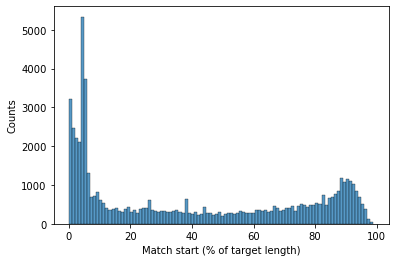

In [7]:
sns.histplot(data=df, x='pct_start', bins=100)
plt.xlabel('Match start (% of target length)')
plt.ylabel('Counts')

In [8]:
f = len(df[(df.pct_start <= 25)|(df.pct_start >= 75)])*100/len(df)
print(f'{f:.2}% of hits begin in the initial or final 25% of target protein')

7.3e+01% of hits begin in the initial or final 25% of target protein


### Enrichment of ortholog groups among the homologs

In [9]:
data = pd.read_table('data/adjust_significant_function.csv.xz', sep=',')
data = data.sort_values(by='times')

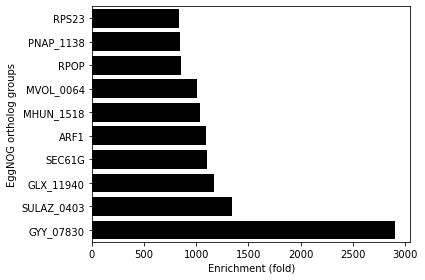

In [10]:
sns.barplot(data=data.tail(10), x='times', y='eggnog_OG', orient='h', color='black')
plt.xlabel('Enrichment (fold)')
plt.ylabel('EggNOG ortholog groups')
plt.tight_layout()

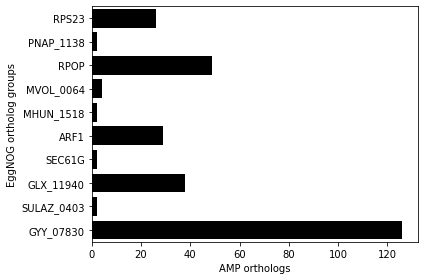

In [11]:
sns.barplot(data=data.tail(10), x='count_AMP', y='eggnog_OG', orient='h', color='black')
plt.xlabel('AMP orthologs')
plt.ylabel('EggNOG ortholog groups')
plt.tight_layout()

In [12]:
data = pd.read_table('data/amp_COG.tsv.xz', names=['cog_class', 'count_AMP', 'fraction'])
data = data.sort_values(by='count_AMP')

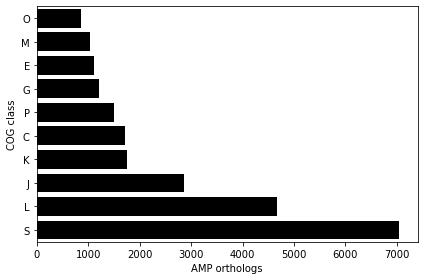

In [13]:
sns.barplot(data=data.tail(10), x='count_AMP', y='cog_class', orient='h', color='black')
plt.ylabel('COG class')
plt.xlabel('AMP orthologs')
plt.tight_layout()